In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# === Path and ticker mapping ===
predicted_data_folder = r"Pred_Data"

ticker_to_basename = {
    "^NSEI": "NIFTY_50",
    "^NSEBANK": "NIFTY_BANK",
    "^CNXIT": "NIFTY_IT",
    "^CNXPHARMA": "NIFTY_PHARMA",
    "^CNXFMCG": "NIFTY_FMCG",
    "^CNXAUTO": "NIFTY_AUTO",
    "^CNXMETAL": "NIFTY_METAL",
    "^CNXREALTY": "NIFTY_REALTY",
    "^CNXENERGY": "NIFTY_ENERGY",
    "NIFTY_FIN_SERVICE.NS": "NIFTY_FIN_SERVICE",
    "RELIANCE.NS": "RELIANCE_INDUSTRIES_LTD",
    "TCS.NS": "TATA_CONSULTANCY_SERV_LT",
    "SUNPHARMA.NS": "SUN_PHARMACEUTICAL_IND_L",
    "ICICIBANK.NS": "ICICI_BANK_LTD.",
    "INFY.NS": "INFOSYS_LIMITED",
    "SBIN.NS": "STATE_BANK_OF_INDIA",
    "BHARTIARTL.NS": "BHARTI_AIRTEL_LIMITED",
    "ITC.NS": "ITC_LTD",
    "LT.NS": "LARSEN_&_TOUBRO_LTD.",
    "HINDUNILVR.NS": "HINDUSTAN_UNILEVER_LTD."
}

In [3]:
def simulate_investment(df, amt, start_date, end_date, plot=False):
    df = df.copy()

    if 'Datetime' in df.index.names:
        df = df.reset_index()

    if 'Datetime' not in df.columns:
        raise ValueError("No 'Datetime' column found after reset_index.")

    df["Datetime"] = pd.to_datetime(df["Datetime"])
    df = df.sort_values("Datetime").reset_index(drop=True)

    # ---- Filter to start/end range ----
    actual_start = df[df["Datetime"] >= pd.to_datetime(start_date)]
    if actual_start.empty:
        raise ValueError("No data after the given start_date")
    start_row = actual_start.iloc[0]

    actual_end = df[df["Datetime"] <= pd.to_datetime(end_date)]
    if actual_end.empty:
        raise ValueError("No data before the given end_date")
    end_row = actual_end.iloc[-1]

    df = df[(df["Datetime"] >= start_row["Datetime"]) & (df["Datetime"] <= end_row["Datetime"])].reset_index(drop=True)

    # ---- Compute predicted and actual returns ----
    df["pred_return"] = df["PredictedPrice"].pct_change()
    df["actual_return"] = df["ActualPrice"].pct_change()

    invested = False
    cash = amt
    values = [cash]  # track value over time

    for i in range(1, len(df)):
        signal = df.loc[i, "pred_return"]
        actual_r = df.loc[i, "actual_return"]

        # If model predicts profit
        if signal > 0:
            if not invested:
                invested = True
            cash *= (1 + actual_r)
        else:
            if invested:
                invested = False
        values.append(cash)

    df["InvestmentValue"] = values

    final_value = df["InvestmentValue"].iloc[-1]
    profit_pct = ((final_value - amt) / amt) * 100

    summary = {
        "Initial Date Given": start_date,
        "Actual date of investment": str(start_row["Datetime"].date()),
        "Final Date Given": end_date,
        "Actual date of withdraw": str(end_row["Datetime"].date()),
        "Initial Amount": amt,
        "Final Amount": round(final_value, 2),
        "Return (%)": round(profit_pct, 2)
    }

    return summary


In [4]:
actual_returns = {}
expected_returns = {}

start_date = "2025-10-01"
end_date = "2025-11-06"

for ticker, basename in ticker_to_basename.items():
    file_path = os.path.join(predicted_data_folder, f"{basename}_predictions_xgboost.csv")
    if not os.path.exists(file_path):
        print(f"⚠️ Missing: {basename}")
        continue

    df = pd.read_csv(file_path, parse_dates=["Datetime"])
    df = df.replace([-np.inf, np.inf], np.nan).dropna(subset=["ActualPrice", "PredictedPrice"])

    if len(df) <= 300:
        print(f"⚠️ Skipping {basename} — insufficient valid rows.")
        continue
    df = df.iloc[300:].copy()

    df["Actual_Return"] = df["ActualPrice"].pct_change()
    actual_returns[basename] = df.set_index("Datetime")["Actual_Return"].dropna()

    # Expected return via simulation
    try:
        sim = simulate_investment(df, amt=100000, start_date=start_date, end_date=end_date, plot=False)
        exp_ret = sim["Return (%)"] / 100.0
        expected_returns[basename] = exp_ret
        print(f"{basename}: Expected Return {exp_ret:.3f}")
    except Exception as e:
        print(f"Simulation failed for {basename}: {e}")

# Convert to DataFrames
actual_df = pd.concat(actual_returns, axis=1).dropna()
cov_matrix = actual_df.cov()
expected_return_series = pd.Series(expected_returns)


NIFTY_50: Expected Return 0.038
NIFTY_BANK: Expected Return 0.041
NIFTY_IT: Expected Return 0.057
NIFTY_PHARMA: Expected Return 0.018
NIFTY_FMCG: Expected Return 0.078
NIFTY_AUTO: Expected Return 0.008
NIFTY_METAL: Expected Return 0.051
NIFTY_REALTY: Expected Return 0.045
NIFTY_ENERGY: Expected Return 0.037
NIFTY_FIN_SERVICE: Expected Return 0.046
RELIANCE_INDUSTRIES_LTD: Expected Return 0.067
TATA_CONSULTANCY_SERV_LT: Expected Return 0.027
HDFC_BANK_LTD: Expected Return -0.003
ICICI_BANK_LTD.: Expected Return -0.002
INFOSYS_LIMITED: Expected Return 0.076
STATE_BANK_OF_INDIA: Expected Return 0.082
BHARTI_AIRTEL_LIMITED: Expected Return 0.092
ITC_LTD: Expected Return 0.064
LARSEN_&_TOUBRO_LTD.: Expected Return -0.002
HINDUSTAN_UNILEVER_LTD.: Expected Return 0.036


In [5]:
print("\nCovariance Matrix (from Actual Prices):")
cov_matrix.round(6)


Covariance Matrix (from Actual Prices):


,NIFTY_50,NIFTY_BANK,NIFTY_IT,NIFTY_PHARMA,NIFTY_FMCG,NIFTY_AUTO,NIFTY_METAL,NIFTY_REALTY,NIFTY_ENERGY,NIFTY_FIN_SERVICE,RELIANCE_INDUSTRIES_LTD,TATA_CONSULTANCY_SERV_LT,HDFC_BANK_LTD,ICICI_BANK_LTD.,INFOSYS_LIMITED,STATE_BANK_OF_INDIA,BHARTI_AIRTEL_LIMITED,ITC_LTD,LARSEN_&_TOUBRO_LTD.,HINDUSTAN_UNILEVER_LTD.
NIFTY_50,0.000009,0.000009,0.000009,0.000006,0.000005,0.000010,0.000012,0.000011,0.000011,0.000009,0.000010,0.000007,0.000007,0.000009,0.000009,0.000011,0.000008,0.000006,0.000011,0.000004
NIFTY_BANK,0.000009,0.000012,0.000006,0.000005,0.000004,0.000009,0.000011,0.000012,0.000011,0.000012,0.000009,0.000005,0.000011,0.000012,0.000006,0.000014,0.000007,0.000004,0.000010,0.000002
NIFTY_IT,0.000009,0.000006,0.000023,0.000006,0.000005,0.000009,0.000011,0.000009,0.000009,0.000007,0.000008,0.000019,0.000003,0.000006,0.000024,0.000007,0.000007,0.000005,0.000009,0.000003
NIFTY_PHARMA,0.000006,0.000005,0.000006,0.000014,0.000004,0.000008,0.000011,0.000009,0.000009,0.000005,0.000007,0.000004,0.000003,0.000004,0.000005,0.000006,0.000005,0.000003,0.000008,0.000003
NIFTY_FMCG,0.000005,0.000004,0.000005,0.000004,0.000011,0.000006,0.000005,0.000005,0.000005,0.000004,0.000006,0.000004,0.000003,0.000003,0.000005,0.000004,0.000004,0.000011,0.000004,0.000012
NIFTY_AUTO,0.000010,0.000009,0.000009,0.000008,0.000006,0.000020,0.000016,0.000015,0.000014,0.000009,0.000011,0.000007,0.000005,0.000008,0.000008,0.000011,0.000009,0.000005,0.000012,0.000005
NIFTY_METAL,0.000012,0.000011,0.000011,0.000011,0.000005,0.000016,0.000031,0.000020,0.000021,0.000011,0.000014,0.000007,0.000007,0.000009,0.000010,0.000017,0.000009,0.000005,0.000017,0.000002
NIFTY_REALTY,0.000011,0.000012,0.000009,0.000009,0.000005,0.000015,0.000020,0.000038,0.000019,0.000012,0.000013,0.000006,0.000010,0.000010,0.000007,0.000016,0.000009,0.000005,0.000017,0.000002
NIFTY_ENERGY,0.000011,0.000011,0.000009,0.000009,0.000005,0.000014,0.000021,0.000019,0.000023,0.000011,0.000016,0.000006,0.000006,0.000009,0.000007,0.000017,0.000008,0.000005,0.000018,0.000002
NIFTY_FIN_SERVICE,0.000009,0.000012,0.000007,0.000005,0.000004,0.000009,0.000011,0.000012,0.000011,0.000012,0.000009,0.000005,0.000012,0.000012,0.000006,0.000013,0.000007,0.000004,0.000010,0.000002


In [6]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

def _corr_distance(corr):
    # distance matrix from correlation (positive-definite handling)
    corr = corr.clip(-0.9999, 0.9999)
    dist = np.sqrt(0.5 * (1.0 - corr))
    return dist

def _get_quasi_diag(link):
    # order leaves so that similar items stay close (as in HRP)
    # (adapted from Lopez de Prado's HRP)
    link = link.astype(int)
    sort_ix = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]  # number of original items
    while sort_ix.max() >= num_items:
        sort_ix.index = range(0, sort_ix.shape[0] * 2, 2)
        df0 = sort_ix[sort_ix >= num_items]
        i = df0.index
        j = df0.values - num_items
        sort_ix[i] = link[j, 0]
        df1 = pd.Series(link[j, 1], index=i + 1)
        sort_ix = pd.concat([sort_ix, df1]).sort_index()
        sort_ix = sort_ix.astype(int)
    return sort_ix.tolist()

def _get_cluster_var(cov, items):
    subcov = cov[np.ix_(items, items)]
    inv_var = 1.0 / np.diag(subcov)
    w = inv_var / inv_var.sum()
    var = w @ subcov @ w
    return var

def _hrp_allocation(cov, sort_ix):
    """
    Compute Hierarchical Risk Parity (HRP) allocation using recursive bisection.
    cov: covariance matrix (already reordered)
    sort_ix: ordered list of asset indices after clustering
    Returns: pd.Series of HRP weights indexed by sort_ix
    """
    w = pd.Series(1.0, index=sort_ix)
    clusters = [sort_ix]

    # Recursive bisection
    while clusters:
        new_clusters = []
        for cluster in clusters:
            if len(cluster) <= 1:
                continue

            # Split cluster into two halves
            split = len(cluster) // 2
            c1 = cluster[:split]
            c2 = cluster[split:]

            var1 = _get_cluster_var(cov, c1)
            var2 = _get_cluster_var(cov, c2)
            alpha = 1.0 - var1 / (var1 + var2)

            # Scale weights inversely to risk
            w[c1] *= alpha
            w[c2] *= (1.0 - alpha)

            # Queue the new clusters for the next round
            new_clusters.extend([c1, c2])

        clusters = new_clusters

    # Normalize weights to sum to 1
    w /= w.sum()
    return w


def _apply_tilt(weights, tilt_vec, tilt_strength=0.3):
    """
    Semi-supervised tilt: blend HRP weights with a soft preference vector.
    tilt_vec should be non-negative and sum to one (we’ll fix if not).
    """
    t = np.maximum(tilt_vec, 0)
    if t.sum() == 0:
        return weights
    t = t / t.sum()
    w = (1.0 - tilt_strength) * weights + tilt_strength * t
    w = np.maximum(w, 0)
    return w / w.sum()

def optimize_ml_portfolio(window_df, tilt=None, tilt_strength=0.3):
    """
    ML (unsupervised / semi-supervised) optimizer using HRP.
    - window_df: DataFrame of recent ACTUAL returns (rows=time, cols=assets)
    - tilt: optional Series/ndarray of weak signals per asset (e.g., Predicted drift or simulated ER)
            same order as window_df.columns
    - tilt_strength: in [0,1], 0=no tilt (pure HRP), 1=all tilt
    Returns: numpy array of weights aligned to window_df.columns
    """
    # robust covariance/correlation
    ret = window_df.dropna(how="any")
    if ret.shape[0] < 10:
        # fallback to equal weight if too little data
        return np.ones(ret.shape[1]) / ret.shape[1]

    cov = ret.cov().values
    corr = ret.corr().values
    dist = _corr_distance(corr)
    # SciPy linkage expects condensed distance
    Z = linkage(squareform(dist, checks=False), method="single")
    sort_ix = _get_quasi_diag(Z)
    # reorder covariance accordingly
    cov_reordered = cov[np.ix_(sort_ix, sort_ix)]
    hrp_w = _hrp_allocation(cov_reordered, sort_ix)

    # Map back to original column order
    # hrp_w is indexed by positions sort_ix; build full vector accordingly
    w_sorted = np.zeros_like(hrp_w.values)
    w_sorted[:] = hrp_w.values
    w_full = np.zeros(cov.shape[0])
    for idx_pos, asset_pos in enumerate(sort_ix):
        w_full[asset_pos] = w_sorted[idx_pos]

    # Optional semi-supervised tilt
    if tilt is not None:
        tvec = np.asarray(tilt, dtype=float)
        # ensure same order as columns
        if tvec.shape[0] != w_full.shape[0]:
            raise ValueError("tilt vector length must match number of assets")
        w_full = _apply_tilt(w_full, tvec, tilt_strength)

    return w_full


In [7]:
# import os
# import numpy as np
# import pandas as pd

# def ml_portfolio_simulation(predicted_data_folder, ticker_to_basename,
#                             apply_date, withdraw_date, k=3,
#                             use_tilt=True, tilt_strength=0.3):
#     """
#     Rolling ML portfolio simulation using HRP (unsupervised) with optional semi-supervised tilt.
#     - Uses past k days to estimate structure/covariance.
#     - If use_tilt=True, builds a weak signal tilt from PredictedPrice drift in the window.
#     Returns:
#       summary: dict with Invest_Day, Withdraw_Day, Lookback_Days, Total_Return, Average_Risk
#       weights_history: DataFrame (index=timestamp, columns=assets) of weights
#     """
#     # 1) Load/align returns & optional tilt signals
#     all_returns = {}
#     all_pred = {}

#     for _, basename in ticker_to_basename.items():
#         fp = os.path.join(predicted_data_folder, f"{basename}_predictions_xgboost.csv")
#         if not os.path.exists(fp):
#             continue
#         df = pd.read_csv(fp, parse_dates=["Datetime"])
#         df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["ActualPrice"])
#         if len(df) <= 300:
#             continue
#         df = df.iloc[300:].copy()
#         df["Actual_Return"] = df["ActualPrice"].pct_change()
#         df = df.set_index("Datetime")
#         # extend window back by k days for rolling start
#         start = pd.to_datetime(apply_date) - pd.Timedelta(days=k)
#         mask = (df.index >= start) & (df.index <= pd.to_datetime(withdraw_date))
#         dff = df.loc[mask]
#         if dff.empty:
#             continue
#         all_returns[basename] = dff["Actual_Return"]
#         if use_tilt and "PredictedPrice" in dff.columns:
#             all_pred[basename] = dff["PredictedPrice"]

#     if not all_returns:
#         raise ValueError("No valid assets found for the given period.")

#     actual_df = pd.concat(all_returns, axis=1).dropna()
#     assets = list(actual_df.columns)

#     # Timepoints to trade
#     trade_times = actual_df.loc[
#         (actual_df.index >= pd.to_datetime(apply_date)) &
#         (actual_df.index <= pd.to_datetime(withdraw_date))
#     ].index.unique()

#     weights_history = pd.DataFrame(index=trade_times, columns=assets, dtype=float)
#     step_returns = []

#     for t in trade_times:
#         # Window
#         wstart = t - pd.Timedelta(days=k)
#         window_df = actual_df.loc[(actual_df.index > wstart) & (actual_df.index <= t)]
#         if window_df.shape[0] < 10:
#             continue

#         # Optional semi-supervised tilt from PredictedPrice drift over the window
#         tilt_vec = None
#         if use_tilt and len(all_pred) == len(assets):
#             preds = pd.concat({a: all_pred[a] for a in assets}, axis=1).dropna()
#             preds_win = preds.loc[(preds.index > wstart) & (preds.index <= t)]
#             if not preds_win.empty:
#                 # drift (last/first - 1), clipped to non-neg and normalized inside optimizer
#                 tilt_vec = (preds_win.iloc[-1] / preds_win.iloc[0] - 1.0).values

#         # HRP optimize (with tilt if provided)
#         w = optimize_ml_portfolio(window_df, tilt=tilt_vec, tilt_strength=tilt_strength)
#         weights_history.loc[t, :] = w

#         # Apply weights to realized return at time t
#         step_ret = float(np.dot(w, actual_df.loc[t, :].values))
#         step_returns.append(step_ret)

#     step_returns = np.array(step_returns)
#     total_return = np.prod(1.0 + step_returns) - 1.0
#     avg_risk = float(np.std(step_returns))

#     summary = {
#         "Invest_Day": str(apply_date),
#         "Withdraw_Day": str(withdraw_date),
#         "Lookback_Days": int(k),
#         "Total_Return": float(total_return),
#         "Average_Risk": avg_risk
#     }

#     print("\n=== ML (HRP) Portfolio Simulation ===")
#     print(f"Investment Period: {apply_date} → {withdraw_date}")
#     print(f"Lookback Window: {k} days | Tilt: {'ON' if use_tilt else 'OFF'} (strength={tilt_strength})")
#     print(f"Total Return: {total_return:.4%}")
#     print(f"Average Risk (Volatility): {avg_risk:.6f}")
#     print(f"Total Time Steps: {len(step_returns)}")

#     return summary, weights_history


In [8]:
# summary_ml, weights_ml = ml_portfolio_simulation(
#     predicted_data_folder=predicted_data_folder,
#     ticker_to_basename=ticker_to_basename,
#     apply_date="2025-10-01",
#     withdraw_date="2025-10-20",
#     k=30,
#     use_tilt=True,        # set False for pure unsupervised HRP
#     tilt_strength=0.25    # 0..1; higher = more tilt toward weak signal
# )


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from scipy.optimize import minimize

# =============================
# --- Helper Functions ---
# =============================

def _corr_distance(corr):
    corr = corr.clip(-0.9999, 0.9999)
    dist = np.sqrt(0.5 * (1.0 - corr))
    return dist


def _get_quasi_diag(link):
    link = link.astype(int)
    sort_ix = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]
    while sort_ix.max() >= num_items:
        sort_ix.index = range(0, sort_ix.shape[0] * 2, 2)
        df0 = sort_ix[sort_ix >= num_items]
        i = df0.index
        j = df0.values - num_items
        sort_ix[i] = link[j, 0]
        df1 = pd.Series(link[j, 1], index=i + 1)
        sort_ix = pd.concat([sort_ix, df1]).sort_index()
        sort_ix = sort_ix.astype(int)
    return sort_ix.tolist()


def _get_cluster_var(cov, items):
    subcov = cov[np.ix_(items, items)]
    inv_var = 1.0 / np.diag(subcov)
    w = inv_var / inv_var.sum()
    var = w @ subcov @ w
    return var


# =============================
# --- HRP Allocation ---
# =============================

def _hrp_allocation(cov, sort_ix):
    w = pd.Series(1.0, index=sort_ix)
    clusters = [sort_ix]

    while clusters:
        new_clusters = []
        for cluster in clusters:
            if len(cluster) <= 1:
                continue
            split = len(cluster) // 2
            c1 = cluster[:split]
            c2 = cluster[split:]
            var1 = _get_cluster_var(cov, c1)
            var2 = _get_cluster_var(cov, c2)
            alpha = 1.0 - var1 / (var1 + var2)
            w[c1] *= alpha
            w[c2] *= (1.0 - alpha)
            new_clusters.extend([c1, c2])
        clusters = new_clusters
    w /= w.sum()
    return w


# =============================
# --- HERC Allocation ---
# =============================

def _get_erc_weights(cov, tol=1e-8):
    """Equal Risk Contribution weights solver for small cov matrix."""
    n = cov.shape[0]
    if n == 1:
        return np.array([1.0])
    vol = np.sqrt(np.diag(cov))
    x0 = (1.0 / np.where(vol > 0, vol, 1.0))
    x0 = x0 / x0.sum()

    def obj(w):
        w = np.maximum(w, 0)
        rc = w * (cov @ w)
        mean_rc = rc.sum() / len(rc)
        return ((rc - mean_rc) ** 2).sum()

    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},)
    bounds = [(0.0, 1.0) for _ in range(n)]

    res = minimize(obj, x0, method='SLSQP', bounds=bounds, constraints=cons,
                   options={'ftol': tol, 'maxiter': 1000})
    if not res.success:
        inv_var = 1.0 / np.diag(cov)
        inv_var[np.isinf(inv_var)] = 0.0
        return inv_var / inv_var.sum()
    w_opt = np.maximum(res.x, 0)
    return w_opt / w_opt.sum()


def _herc_allocation(cov, sort_ix):
    """Hierarchical Equal Risk Contribution (HERC) allocation."""
    def recurse(cluster_positions):
        if len(cluster_positions) == 1:
            return pd.Series([1.0], index=[cluster_positions[0]], dtype=float)
        split = len(cluster_positions) // 2
        c1, c2 = cluster_positions[:split], cluster_positions[split:]
        cov_c1 = cov[np.ix_(c1, c1)]
        cov_c2 = cov[np.ix_(c2, c2)]
        w_c1_local = _get_erc_weights(cov_c1)
        w_c2_local = _get_erc_weights(cov_c2)
        var1 = float(w_c1_local @ (cov_c1 @ w_c1_local))
        var2 = float(w_c2_local @ (cov_c2 @ w_c2_local))
        alpha = 0.5 if (var1 + var2) <= 0 else 1.0 - var1 / (var1 + var2)
        out_c1 = recurse(c1) * alpha
        out_c2 = recurse(c2) * (1.0 - alpha)
        return pd.concat([out_c1, out_c2])

    out = recurse(list(sort_ix))
    out = out / out.sum()
    return out.reindex(sort_ix)


# =============================
# --- Tilt (Semi-supervised blend) ---
# =============================

def _apply_tilt(weights, tilt_vec, tilt_strength=0.3):
    t = np.maximum(tilt_vec, 0)
    if t.sum() == 0:
        return weights
    t = t / t.sum()
    w = (1.0 - tilt_strength) * weights + tilt_strength * t
    w = np.maximum(w, 0)
    return w / w.sum()


# =============================
# --- Portfolio Optimizer ---
# =============================

def optimize_ml_portfolio(window_df, tilt=None, tilt_strength=0.3, use_herc=False):
    """Core optimizer: HRP (default) or HERC (if use_herc=True)."""
    ret = window_df.dropna(how="any")
    if ret.shape[0] < 10:
        return np.ones(ret.shape[1]) / ret.shape[1]
    cov = ret.cov().values
    corr = ret.corr().values
    dist = _corr_distance(corr)
    Z = linkage(squareform(dist, checks=False), method="single")
    sort_ix = _get_quasi_diag(Z)
    cov_reordered = cov[np.ix_(sort_ix, sort_ix)]

    alloc = _herc_allocation(cov_reordered, sort_ix) if use_herc else _hrp_allocation(cov_reordered, sort_ix)
    w_full = np.zeros(cov.shape[0])
    for idx_pos, asset_pos in enumerate(sort_ix):
        w_full[asset_pos] = alloc.values[idx_pos]
    if tilt is not None:
        w_full = _apply_tilt(w_full, np.asarray(tilt, float), tilt_strength)
    return w_full


# =============================
# --- Main Simulation Function ---
# =============================

def ml_portfolio_simulation(predicted_data_folder, ticker_to_basename,
                            apply_date, withdraw_date, k=3,
                            use_tilt=True, tilt_strength=0.3,
                            use_herc=False):
    """Rolling HRP/HERC portfolio simulation."""
    all_returns, all_pred = {}, {}
    for _, basename in ticker_to_basename.items():
        fp = os.path.join(predicted_data_folder, f"{basename}_predictions_xgboost.csv")
        if not os.path.exists(fp):
            continue
        df = pd.read_csv(fp, parse_dates=["Datetime"])
        df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["ActualPrice"])
        if len(df) <= 300:
            continue
        df = df.iloc[300:].copy()
        df["Actual_Return"] = df["ActualPrice"].pct_change()
        if "PredictedPrice" in df.columns:
            df["Predicted_Return"] = df["PredictedPrice"].pct_change()
        df = df.set_index("Datetime")
        start = pd.to_datetime(apply_date) - pd.Timedelta(days=k)
        mask = (df.index >= start) & (df.index <= pd.to_datetime(withdraw_date))
        dff = df.loc[mask]
        if dff.empty:
            continue
        all_returns[basename] = dff["Actual_Return"]
        if use_tilt and "Predicted_Return" in dff.columns:
            all_pred[basename] = dff["Predicted_Return"]

    if not all_returns:
        raise ValueError("No valid assets found for given period.")

    actual_df = pd.concat(all_returns, axis=1).dropna()
    predicted_df = None
    if all_pred:
        predicted_df = pd.concat(all_pred, axis=1).reindex(actual_df.index).fillna(0)

    assets = list(actual_df.columns)
    trade_times = actual_df.loc[
        (actual_df.index >= pd.to_datetime(apply_date)) &
        (actual_df.index <= pd.to_datetime(withdraw_date))
    ].index.unique()

    weights_history = pd.DataFrame(index=trade_times, columns=assets, dtype=float)
    step_returns = []

    for t in trade_times:
        wstart = t - pd.Timedelta(days=k)
        window_df = actual_df.loc[(actual_df.index > wstart) & (actual_df.index <= t)]
        if window_df.shape[0] < 10:
            continue
        tilt_vec = None
        if use_tilt and len(all_pred) == len(assets):
            preds = pd.concat({a: all_pred[a] for a in assets}, axis=1).dropna()
            preds_win = preds.loc[(preds.index > wstart) & (preds.index <= t)]
            if not preds_win.empty:
                tilt_vec = (preds_win.iloc[-1] / preds_win.iloc[0] - 1.0).values
        w = optimize_ml_portfolio(window_df, tilt=tilt_vec,
                                  tilt_strength=tilt_strength,
                                  use_herc=use_herc)
        weights_history.loc[t, :] = w
        step_returns.append(float(np.dot(w, actual_df.loc[t, :].values)))

    step_returns = np.array(step_returns)
    total_return = np.prod(1.0 + step_returns) - 1.0
    avg_risk = float(np.std(step_returns))
    z_score = 1.65
    mu_p, sigma_p = np.mean(step_returns), np.std(step_returns)
    var_parametric = -(mu_p - z_score * sigma_p)
    var_historical = -np.percentile(step_returns, 5)

    realized_value = 100 * (1 + pd.Series(step_returns, index=trade_times)).cumprod()
    return_df = pd.DataFrame({
        "Datetime": realized_value.index,
        "Realized_Portfolio_Value": realized_value.values
    }).reset_index(drop=True)

    method_name = "HERC" if use_herc else "HRP"
    summary = {
        "Method": method_name,
        "Invest_Day": str(apply_date),
        "Withdraw_Day": str(withdraw_date),
        "Lookback_Days": int(k),
        "Total_Return": float(total_return),
        "Average_Risk": avg_risk,
        "Parametric_VaR": float(var_parametric),
        "Historical_VaR": float(var_historical),
        "Confidence_Level": 0.95
    }

    print(f"\n=== ML Portfolio Simulation ({method_name}) ===")
    print(f"Period: {apply_date} → {withdraw_date}")
    print(f"Lookback: {k}d | Tilt: {'ON' if use_tilt else 'OFF'} (strength={tilt_strength})")
    print(f"Total Return: {total_return:.2%}")
    print(f"Volatility: {avg_risk:.6f}")
    print(f"Parametric VaR (95%): {var_parametric:.2%}")
    print(f"Historical VaR (95%): {var_historical:.2%}")
    print(f"Steps simulated: {len(step_returns)}")

    plt.figure(figsize=(10, 5))
    plt.plot(return_df["Datetime"], return_df["Realized_Portfolio_Value"], color='royalblue', lw=2)
    plt.title(f"{method_name} Realized Portfolio — ₹100 Investment Growth")
    plt.xlabel("Datetime")
    plt.ylabel("Portfolio Value (₹)")
    plt.grid(True, linestyle='--', alpha=0.6)
    final_val = return_df["Realized_Portfolio_Value"].iloc[-1]
    plt.text(return_df["Datetime"].iloc[-1], final_val, f" ₹{final_val:.2f}",
             fontsize=10, color='black', ha='left', va='center')
    plt.tight_layout()
    plt.show()

    return summary, weights_history, return_df



=== ML Portfolio Simulation (HERC) ===
Period: 2025-04-06 → 2025-11-06
Lookback: 80d | Tilt: ON (strength=1)
Total Return: 31.72%
Volatility: 0.004651
Parametric VaR (95%): 0.74%
Historical VaR (95%): 0.53%
Steps simulated: 998


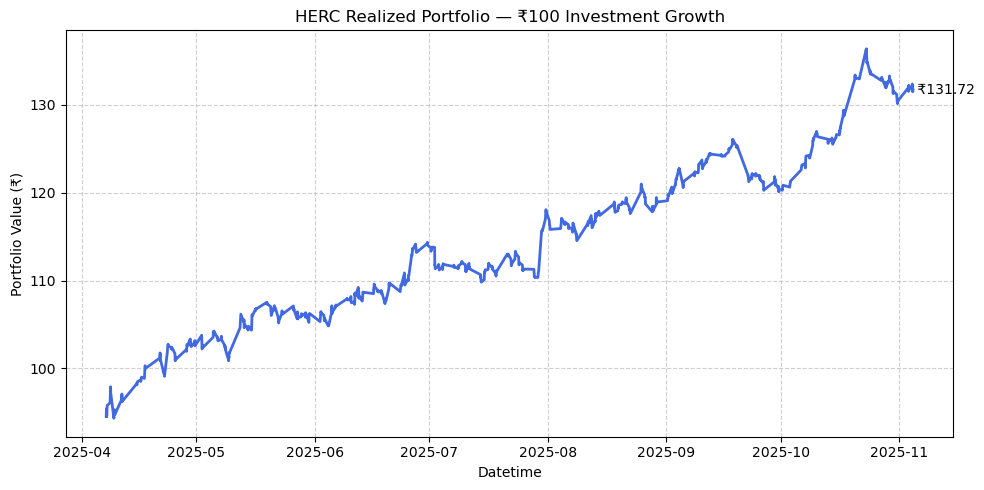

In [16]:
summary_ml, weights_ml, result_df = ml_portfolio_simulation(
    predicted_data_folder=predicted_data_folder,
    ticker_to_basename=ticker_to_basename,
    apply_date="2025-04-06",
    withdraw_date="2025-11-06",
    k=80,
    use_tilt=True,        # set False for pure unsupervised HRP
    tilt_strength=1,  # 0..1; higher = more tilt toward weak signal
    use_herc=True
)

In [11]:
result_df

,Datetime,Realized_Portfolio_Value
0,2025-04-07 09:15:00,96.652025
1,2025-04-07 10:15:00,97.221033
2,2025-04-07 11:15:00,97.330986
3,2025-04-07 12:15:00,97.362814
4,2025-04-07 13:15:00,97.622204
...,...,...
993,2025-11-04 11:15:00,119.467174
994,2025-11-04 12:15:00,119.498189
995,2025-11-04 13:15:00,119.685787
996,2025-11-04 14:15:00,119.677772
